In [118]:
import tifffile
import skimage.measure
import zarr
from scipy import ndimage
from skimage import morphology
import numpy as np
from matplotlib import pyplot as plt
import napari
import pandas as pd

In [2]:
sm_tif = tifffile.TiffFile("exemplar-001/segmentation/unmicst-exemplar-001/cellMask.tif", mode="rb")

In [3]:
sm = zarr.open(sm_tif.aszarr(), mode="r")

In [4]:
sm

<zarr.core.Array (3138, 2509) int32 read-only>

In [29]:
np.unique(sm)

array([   0,    1,    2, ..., 9520, 9521, 9522], dtype=int32)

In [5]:
im_tif = tifffile.TiffFile("exemplar-001/registration/exemplar-001.ome.tif", mode="rb")

In [6]:
im = zarr.open(im_tif.aszarr(), mode="r")[0]

In [7]:
bg = sm[...] == 0

In [8]:
dist, (i, j) = ndimage.distance_transform_edt(
    bg, return_indices=True
)

In [9]:
dist.shape

(3138, 2509)

In [10]:
sm_mod = sm[...]

In [11]:
bg

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

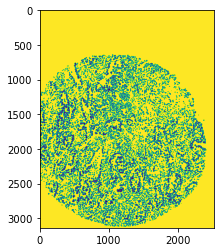

In [12]:
plt.imshow(bg)

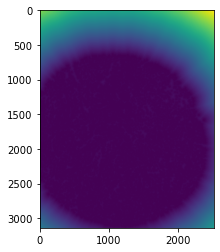

In [13]:
plt.imshow(dist)

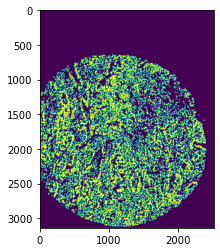

In [14]:
plt.imshow(dist <= 3)

In [15]:
cm = sm[...] != 0

In [16]:
dist, (i, j) = ndimage.distance_transform_edt(
    cm, return_indices=True
)

In [17]:
dist.shape

(3138, 2509)

In [18]:
cm

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

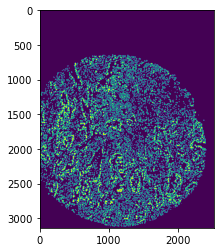

In [19]:
plt.imshow(cm)

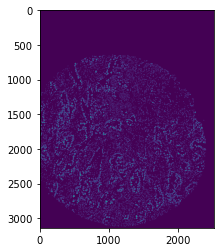

In [20]:
plt.imshow(dist)

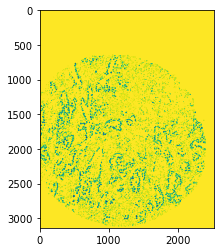

In [21]:
plt.imshow(dist <= 3)

In [22]:
viewer = napari.view_image(dist <= 3)

In [27]:
viewer.add_image(dist)

<Image layer 'dist' at 0x142ede560>

In [23]:
import napari

In [24]:
i.shape

(3138, 2509)

In [49]:
from skimage.measure._regionprops import RegionProperties, _props_to_dict

In [107]:
import pdb

In [133]:
def erode_mask(mask, radius):
    mask_out = mask.copy()
    dist = ndimage.distance_transform_edt(mask != 0)
    mask_out[dist <= radius] = 0
    return mask_out


class LazyExpandedRegions:
    def __init__(self, label_image, intensity_image, radius, extra_properties=None):
        # Copy because we will keep modifying it
        self.label_image = label_image.copy()
        self.intensity_image = intensity_image
        self.radius = radius
        self.dist, (self.ix, self.iy) = ndimage.distance_transform_edt(
            label_image == 0, return_indices=True
        )
        self.objects = ndimage.find_objects(label_image)
        self.extra_properties = extra_properties
        
    def __getitem__(self, x):
        label = x + 1
        sl = self.objects[x]
        sl_expanded = tuple(
            slice(
                max(0, x.start - self.radius),
                min(self.label_image.shape[i], x.stop + self.radius)
            ) for i, x in enumerate(sl)
        )
        li_orig = self.label_image[sl_expanded]
        try:
            li_target = li_orig == label
            li_target = morphology.binary_dilation(
                li_target, footprint=morphology.disk(self.radius)
            )
            li_repl = li_orig.copy()
            li_repl[li_repl != label] = 0
            li_repl[li_target] = label
            # if label == 1:
            #     viewer.add_image(self.label_image.copy())
            self.label_image[sl_expanded] = li_repl
            # if label == 1:
            #     viewer.add_image(self.label_image.copy())
            return RegionProperties(
                sl_expanded, label, self.label_image, self.intensity_image,
                cache_active=True, extra_properties=self.extra_properties
            )
        finally:
            self.label_image[sl_expanded] = li_orig

    def __len__(self):
        return len(self.objects)


def regionprops_tidal(label_image, intensity_image, radii, **kwargs):
    prop_tables = {}
    
    for r in radii:
        if r < 0:
            mask = erode_mask(label_image, radius = abs(r))
            # viewer.add_image(mask)
            prop_tables[r] = skimage.measure.regionprops_table(
                mask, intensity_image, **kwargs
            )
        elif r == 0:
            # viewer.add_image(label_image)
            prop_tables[r] = skimage.measure.regionprops_table(
                label_image, intensity_image, **kwargs
            )
        else:
            extra_properties = kwargs.get("extra_properties", None)
            properties = kwargs.get("properties", ("label", "bbox"))
            if extra_properties is not None:
                properties = list(properties) + [x.__name__ for x in extra_properties]
            prop_tables[r] = _props_to_dict(
                LazyExpandedRegions(
                    label_image, intensity_image, r, extra_properties=extra_properties
                ),
                properties=properties,
                separator=kwargs.get("separator", "-")
            )
    return prop_tables

In [134]:
x = erode_mask(sm[...], 2)

In [135]:
 np.moveaxis(im[...], 0, -1).shape

(3138, 2509, 12)

In [136]:
sm[...].shape

(3138, 2509)

In [137]:
%pdb

Automatic pdb calling has been turned OFF


In [138]:
def signal_sum(label_image, intensity_image):
    return np.sum(intensity_image[label_image])

In [139]:
res = regionprops_tidal(
    sm[...], np.moveaxis(im[...], 0, -1), [-4, -2, 0, 2, 4], properties=("area", "intensity_mean"), extra_properties=[signal_sum]
)

/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chug/opt/miniconda3/envs/celltide/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [116]:
res

{-4: {'area': array([ 2, 16, 22, ...,  3,  1,  4]),
  'intensity_mean-0': array([46009.        , 43264.625     , 46054.68181818, ...,
         54826.        , 59965.        , 38686.5       ]),
  'intensity_mean-1': array([ 694.        , 3208.125     ,  672.09090909, ...,  859.33333333,
          856.        ,  643.5       ]),
  'intensity_mean-2': array([261.5       , 480.75      , 216.40909091, ..., 315.66666667,
         299.        , 242.75      ]),
  'intensity_mean-3': array([ 313.        , 1945.75      ,  297.59090909, ...,  476.        ,
          340.        ,  309.75      ]),
  'intensity_mean-4': array([48527.5       , 45461.75      , 46535.59090909, ...,
         53617.66666667, 64494.        , 40910.        ]),
  'intensity_mean-5': array([439.        , 615.4375    , 397.09090909, ..., 486.        ,
         431.        , 391.75      ]),
  'intensity_mean-6': array([206.5       , 285.5       , 190.59090909, ..., 235.33333333,
         237.        , 162.        ]),
  'intens

In [125]:
y = pd.concat([pd.DataFrame.from_dict(x) for x in res.values()], keys=res.keys(), names=["tide_radius", "row_id"])

In [126]:
y.reset_index()

,tide_radius,row_id,area,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3,intensity_mean-4,intensity_mean-5,intensity_mean-6,...,signal_sum-2,signal_sum-3,signal_sum-4,signal_sum-5,signal_sum-6,signal_sum-7,signal_sum-8,signal_sum-9,signal_sum-10,signal_sum-11
0,-4,0,2,46009.000000,694.000000,261.500000,313.000000,48527.500000,439.000000,206.500000,...,523.0,626.0,97055.0,878.0,413.0,592.0,57195.0,2861.0,1848.0,1654.0
1,-4,1,16,43264.625000,3208.125000,480.750000,1945.750000,45461.750000,615.437500,285.500000,...,7692.0,31132.0,727388.0,9847.0,4568.0,5069.0,436884.0,41000.0,38872.0,32577.0
2,-4,2,22,46054.681818,672.090909,216.409091,297.590909,46535.590909,397.090909,190.590909,...,4761.0,6547.0,1023783.0,8736.0,4193.0,5729.0,556770.0,28777.0,19549.0,16731.0
3,-4,3,6,25963.666667,823.000000,272.000000,438.166667,27169.833333,409.166667,212.333333,...,1632.0,2629.0,163019.0,2455.0,1274.0,1696.0,93625.0,12400.0,5721.0,5265.0
4,-4,4,58,20532.241379,765.517241,275.258621,344.431034,20791.120690,395.896552,190.068966,...,15965.0,19977.0,1205885.0,22962.0,11024.0,16141.0,743239.0,66785.0,50805.0,48940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43915,4,9517,242,24281.298319,612.075630,300.605042,469.521008,24156.823529,361.302521,179.256303,...,71771.0,112306.0,5757342.0,86446.0,42931.0,70643.0,3476887.0,306078.0,160208.0,239003.0
43916,4,9518,160,28347.013333,493.306667,169.271111,284.937778,29428.382222,320.071111,152.897778,...,43428.0,72072.0,7716866.0,80984.0,38251.0,67406.0,4587384.0,218540.0,123650.0,178111.0
43917,4,9519,173,24099.310484,544.794355,211.137097,368.782258,24945.705645,335.173387,173.072581,...,55132.0,97366.0,6288743.0,88321.0,45575.0,78368.0,3655064.0,279199.0,149680.0,232134.0
43918,4,9520,158,29624.089686,604.663677,224.919283,370.251121,29576.587444,365.829596,181.179372,...,53027.0,88191.0,6713975.0,86837.0,43007.0,70319.0,3979824.0,320534.0,187492.0,209424.0


In [127]:
y.to_csv("test_tide.csv")

In [95]:
npsum

<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [ ]:
im

In [44]:
skimage.measure.RegionProperties

AttributeError: module 'skimage.measure' has no attribute 'RegionProperties'

In [35]:
ndimage.disk(2, np.uint8)

AttributeError: module 'scipy.ndimage' has no attribute 'disk'

In [37]:
ndimage.ball(2)

AttributeError: module 'scipy.ndimage' has no attribute 'ball'

In [41]:
morphology.disk(2)

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)